## CMSC320 Project 2
**Dmitri Kontchaev**

## Part 1
**Problem 1**

In this part we will access the sql database and create a pandas dataframe with the total payroll and winning percentage for each team in each year. First we select the relevant data from the Salaries data table, then the data from the Teams data table. These two tables are combined using an inner join on the yearID and teamID columns. This join constructs a dataframe with data where both tables have matches for the specific year and team combination. This ensures that none of the observations are missing from either of the initial tables. Therefore, we do not have to worry about missing data in our calculations. However, this does mean we may have some bias since we ignored some data and did not attempt to impute.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None

sqlite_file = 'lahman2014.sqlite.nosync'
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

payroll_query = "SELECT yearID, teamID, sum(salary) as total_payroll FROM Salaries GROUP BY teamID, yearID ORDER BY teamID"
wins_query = "SELECT yearID, teamID, W, G, 100.0*W/G as winning_percentage, franchID from Teams GROUP by teamID, yearID ORDER BY teamID"

payroll_df = pd.read_sql(payroll_query, conn)
wins_df = pd.read_sql(wins_query, conn)

conn.close()

df = pd.merge(payroll_df, wins_df, how="inner", on=["yearID", "teamID"]) #can tell there is not missing data by running
                                                                         #df.isnull().values.any()
df

,yearID,teamID,total_payroll,W,G,winning_percentage,franchID
0,1997,ANA,31135472.0,84,162,51.851852,ANA
1,1998,ANA,41281000.0,85,162,52.469136,ANA
2,1999,ANA,55388166.0,70,162,43.209877,ANA
3,2000,ANA,51464167.0,82,162,50.617284,ANA
4,2001,ANA,47535167.0,75,162,46.296296,ANA
...,...,...,...,...,...,...,...
853,2010,WAS,61400000.0,69,162,42.592593,WSN
854,2011,WAS,63856928.0,80,161,49.689441,WSN
855,2012,WAS,80855143.0,98,162,60.493827,WSN
856,2013,WAS,113703270.0,86,162,53.086420,WSN


## Part 2
**Problem 2**

In this part we plot the distribution of total payroll of a team vs the year. First we take the previously constructed pandas dataframe and gather only the entries where the year is greater than or equal to 1990. Then we pivot the dataframe so that the indices are the year, and each column is a different team with the value being the total payroll. This allows us to use pandas plotting function more easily.



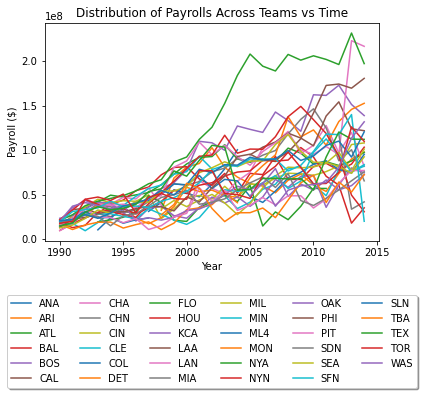

In [2]:
pivoted_df = df.loc[(df["yearID"] >= 1990)].pivot(index="yearID", columns="teamID", values="total_payroll")
pivoted_df.plot()
plt.xlabel("Year")
plt.ylabel("Payroll ($)")
plt.title("Distribution of Payrolls Across Teams vs Time")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.7), 
          ncol=6, fancybox=True, shadow=True) #Move legend so it is not in the way
plt.show()

**Question 1** <br>
From looking at the plot, it appears that the sum of the payrolls for a team's players has generally increased over time. That is to say, it seems that the central tendency of total payroll for a given year appears to grow as the year number increases. It also seems that there is a much greater spread of cumulative payrolls in the later years with a few teams being able to spend much more money on their teams than the majority.
<br>

**Problem 3** <br>
Here we use pandas mean function to find the mean total payroll for each year and plot it vs time to validate our statement that the mean appears to increase over time.

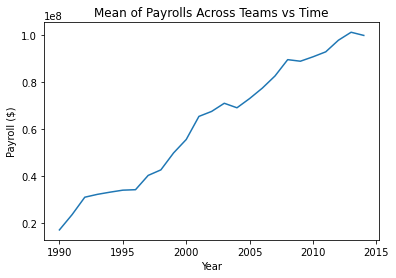

In [3]:

mean_df = pivoted_df.mean(axis=1) # This accounts for the NaN values and does not include them in the mean calculation
mean_df.plot()
plt.xlabel("Year")
plt.ylabel("Payroll ($)")
plt.title("Mean of Payrolls Across Teams vs Time")
plt.show()


The plot clearly shows that the mean payroll did increase over time
<br>
**Problem 4** <br>
In this part we divide the data into five discrete groups which correlate to five time periods. Specifically, the time periods are: <br>
* (1990, 1995]
* (1995, 2000]
* (2000, 2004]
* (2004, 2009]
* (2009, 2014]
<br>

Using these five time periods, we create a scatterplot of winning percentage vs total payroll for each team in each time period. This results in five scatter plots. The trendline helps to see the general pattern of the winning percentage vs total payroll.

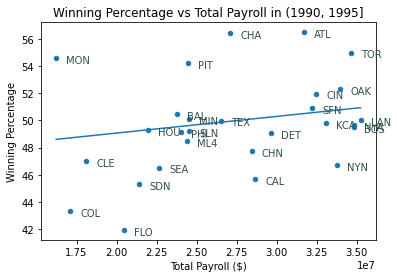

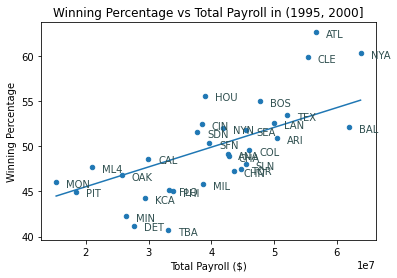

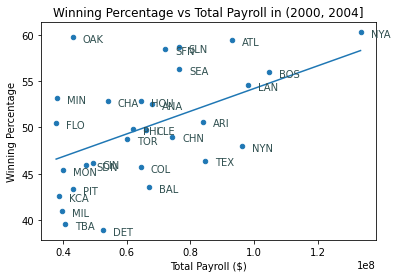

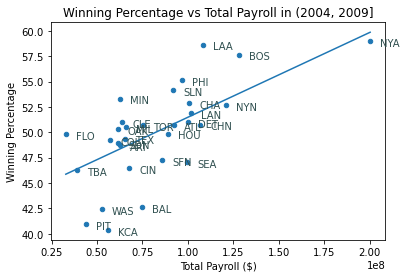

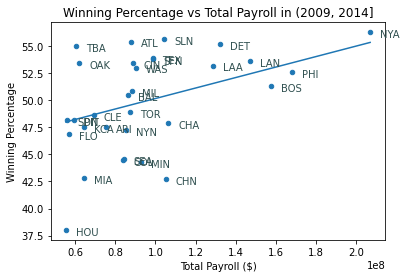

In [4]:
allTeams_df = df.loc[df["yearID"] >= 1990].sort_values(by=["yearID"])

n_bins = 5
_, edges = pd.cut(allTeams_df['yearID'], bins=n_bins, retbins=True)
labels = [f'({abs(edges[i]):.0f}, {edges[i+1]:.0f}]' for i in range(n_bins)]
allTeams_df["range"] = pd.cut(allTeams_df['yearID'], bins=n_bins, labels=labels,  include_lowest=True)

for label in labels:
    range_df = allTeams_df.loc[allTeams_df["range"] == label]

    # get trendline and add to range df
    z = np.polyfit(x=range_df.loc[:,"total_payroll"], y=range_df.loc[:,"winning_percentage"], deg=1)
    p = np.poly1d(z)
    range_df["trendline"] = p(range_df.loc[:, "total_payroll"])

    # create scatter plot
    range_df = range_df.groupby("teamID").mean()
    ax = range_df.plot.scatter(x = "total_payroll", y = "winning_percentage")

    # add point labels
    for k, v in range_df.iterrows():
        ax.annotate(text=k, xy=[v["total_payroll"], v["winning_percentage"]], xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='darkslategrey')
        
    # add trend line
    range_df.set_index("total_payroll", inplace=True)
    range_df.trendline.sort_index(ascending=False).plot(ax=ax)
    plt.title("Winning Percentage vs Total Payroll in " + label)
    plt.ylabel("Winning Percentage")
    plt.xlabel("Total Payroll ($)")
    


**Question 2**<br>
1990-1995: Team MON is the only one that particularly stands out as being efficient with money in terms of wins. <br>
1995-2000: No teams particularly stand out in this time period<br>
2000-2004: Team OAK is the only one that particularly stands out as being efficient with money in terms of wins. This is the Oakland A's<br>
2004-2009: No teams particularly stand out in this time period<br>
2009-2014: Teams TBA, OAK, ATL, and SLN appear to stand out as being efficient with money in terms of wins.<br>
For all five of the team periods, the trendline shows that an increased payroll does tend to lead to a higher winning percentage.
<br>

## Part 3
**Problem 5 and Problem 6** <br>
In this part, we find the standardized payroll for each team in each year. The standardized payroll standardizes a team's total payroll by the mean and standard deviation of the total payrolls for that year. We then recreate the plots from problem 4 with this standardized payroll to better see how a team compared to other teams in terms of payroll vs wins

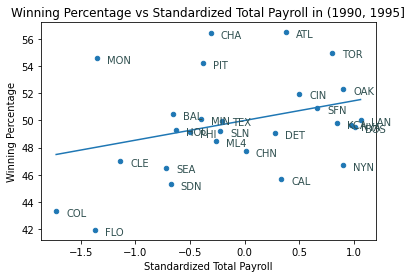

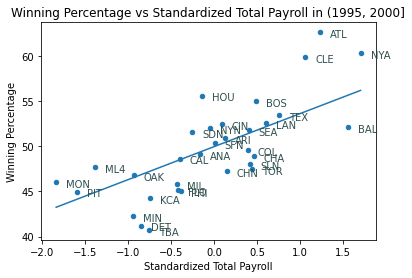

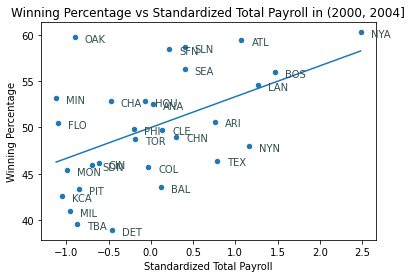

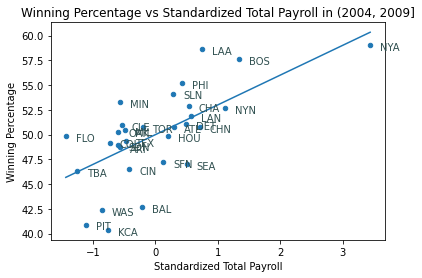

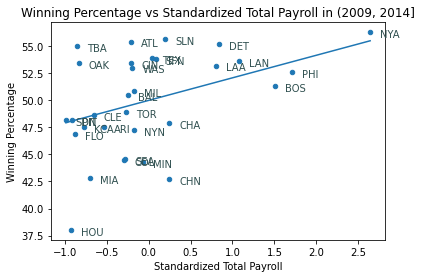

In [5]:
avg_payroll = allTeams_df.groupby(["yearID"])["total_payroll"].mean() # mean payroll for a given year
standard_payroll = allTeams_df.groupby(["yearID"])["total_payroll"].std() # mean std dev for a given year

# add standardized payroll column to allTeams
years = range(1990,2015)
for year in years:
    allTeams_df.loc[allTeams_df['yearID'] == year,"payroll_std"] = ( allTeams_df.loc[( allTeams_df['yearID'] == year)]['total_payroll'] - avg_payroll.loc[year] ) / standard_payroll.loc[year]

for label in labels:
    range_df = allTeams_df.loc[allTeams_df["range"] == label]

    # Find trendline and add it to range df
    z = np.polyfit(x=range_df.loc[:,"payroll_std"], y=range_df.loc[:,"winning_percentage"], deg=1)
    p = np.poly1d(z)
    range_df["trendline"] = p(range_df.loc[:, "payroll_std"])

    # Recreate plots from problem 4 with standardized payroll
    range_df = range_df.groupby("teamID").mean()
    ax = range_df.plot.scatter(x = "payroll_std", y = "winning_percentage")
    for k, v in range_df.iterrows():
        ax.annotate(text=k, xy=[v["payroll_std"], v["winning_percentage"]], xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=10, color='darkslategrey')
    range_df.set_index("payroll_std", inplace=True)
    range_df.trendline.sort_index(ascending=False).plot(ax=ax)
    plt.title("Winning Percentage vs Standardized Total Payroll in " + label)
    plt.ylabel("Winning Percentage")
    plt.xlabel("Standardized Total Payroll")


**Question 3** <br>
The plots that use the standardized payroll instead of total payroll have an x axis which varies from approximately -2 to 3 instead of from approximately 0 to 200,000,000. This makes it easier to see how much teams are paying their players compared to other teams since the x axis is standardized. Overall, the plots are very similar but there are some slight changes in specific data points which changes the trendlines slightly. <br>

**Problem 7** <br>
In this problem we create a scatter plot of winning percentage vs standardized total payroll, except instead of creating such a plot for 5 time periods, we can now do it for all time periods in one plot since we have a standardized payroll.

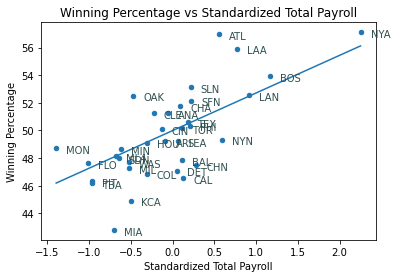

In [6]:
z = np.polyfit(x=allTeams_df.loc[:,"payroll_std"], y=allTeams_df.loc[:,"winning_percentage"], deg=1)
p = np.poly1d(z)
    
allTeams_df["trendline"] = p(allTeams_df.loc[:, "payroll_std"])

allTeamsMean_df = allTeams_df.groupby("teamID").mean()
ax = allTeamsMean_df.plot.scatter(x = "payroll_std", y = "winning_percentage")
for k, v in allTeamsMean_df.iterrows():
    ax.annotate(text=k, xy=[v["payroll_std"], v["winning_percentage"]], xytext=(10,-5), textcoords='offset points',
            family='sans-serif', fontsize=10, color='darkslategrey')
allTeamsMean_df.set_index("payroll_std", inplace=True)
allTeamsMean_df.trendline.sort_index(ascending=False).plot(ax=ax)
plt.title("Winning Percentage vs Standardized Total Payroll")
plt.ylabel("Winning Percentage")
plt.xlabel("Standardized Total Payroll")
plt.show()

The regression line here shows us that if a team spends the mean amount of money on their team, they will win approximately half of their games, and for each unit increase in standardized payroll, a teams winning percentage is projected to increase by 2.5%.
<br>

**Problem 8** <br>

From this regression, we can calculate a teams projected win percentage. We create this as a new column in the all teams df. Then we can create a second new column called efficiency which is the difference between the actual winning percentage and the projected winning percentage. Plotting this efficiency metric vs time for the following five teams: OAK, BOS, NYA, ATL, and TBA. We can compare the Oakland A's efficiency during their Moneyball period to four other "decent" teams.

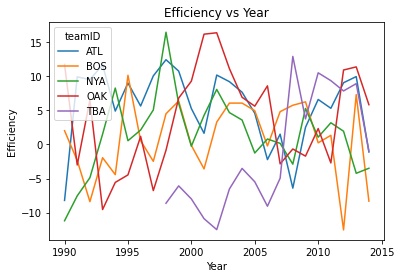

In [7]:
allTeams_df['exp_winning_percentage'] = 50 + 2.5 * allTeams_df["payroll_std"]
allTeams_df['efficiency'] = allTeams_df["winning_percentage"] - allTeams_df["exp_winning_percentage"]

teams = ["OAK", "BOS", "NYA", "ATL", "TBA"]


someTeams_df = allTeams_df.loc[allTeams_df["teamID"].isin(teams)]

someTeams_df = someTeams_df.pivot(index="yearID", columns="teamID", values="efficiency")
someTeams_df.plot()
plt.title("Efficiency vs Year")
plt.ylabel("Efficiency")
plt.xlabel("Year")
plt.show()

**Question 4** <br>
Compared to the plots from questions 2 and 3, this plot makes it much easier to see the change in efficiency of baseball teams over time. The previous plots did a good job of demonstrating the efficiency of a team compared to other teams at the time, but it was difficult to tell just how much the Oakland A's increased in efficiency during their Moneyball period. This plot helps visualize that the Okaland A's really did spike in efficiency significantly during the moneyball period. Before 2000, the graph shows that they were not particularly efficient as a team (actually somewhat inneficient), but when they began implementing the Moneyball strategies they increases their efficiency hugely and were far more efficient than the four other respectable teams shown on the plot. 